## Layoff Prediction Model 2026

In [27]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [prophet]m4/5 [prophet]y]


In [63]:
import pymysql
import pandas as pd
conn = pymysql.connect(
    host='localhost',
    user='root',
    password='*********',
    db='Global_Layoffs'
)
df = pd.read_sql("SELECT * FROM layoffs_staging2", conn)
df.to_csv('/Users/tanmac/Desktop/amazon_sales.csv', index=True)
conn.close()

/var/folders/8g/00b3gbs92n16plbgtl71gh8h0000gn/T/ipykernel_1469/27509444.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM layoffs_staging2", conn)


In [64]:
df2= pd.read_csv(r'/Users/tanmac/Desktop/Rolling avg.csv')
df3= pd.read_csv(r'/Users/tanmac/Desktop/Companies.csv')

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')   
df = df.dropna(subset=['Date'])                        
print("Date dtype:", df['Date'].dtype)                     
df['YearMonth'] = df['Date'].dt.strftime('%Y-%m') 

Date dtype: datetime64[ns]


02:22:25 - cmdstanpy - INFO - Chain [1] start processing
02:22:25 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
02:22:25 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
02:22:26 - cmdstanpy - INFO - Chain [1] start processing


Predicted Total Layoffs per Month in 2026:
        Month  Predicted_Layoffs
70 2026-01-31        9254.083402
71 2026-02-28       25395.377183
72 2026-03-31           0.000000
73 2026-04-30       15311.636598
74 2026-05-31       29888.512615
75 2026-06-30       28046.099559


02:22:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
02:22:26 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
02:22:26 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
02:22:26 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/li


Top 5 companies in 2025 by layoffs: Intel, Microsoft, Meta, Northvolt, Hewlett Packard Enterprise


/opt/anaconda3/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


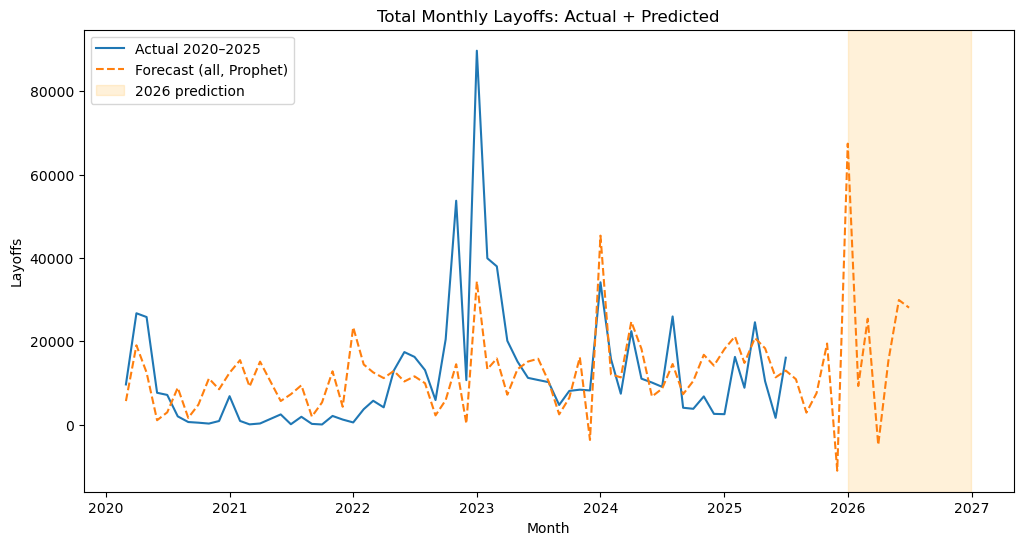

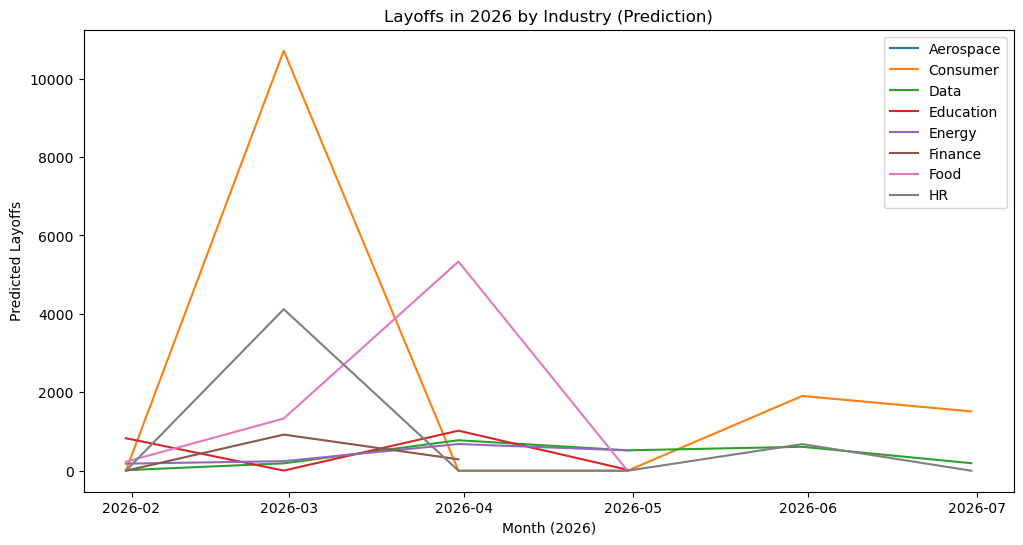

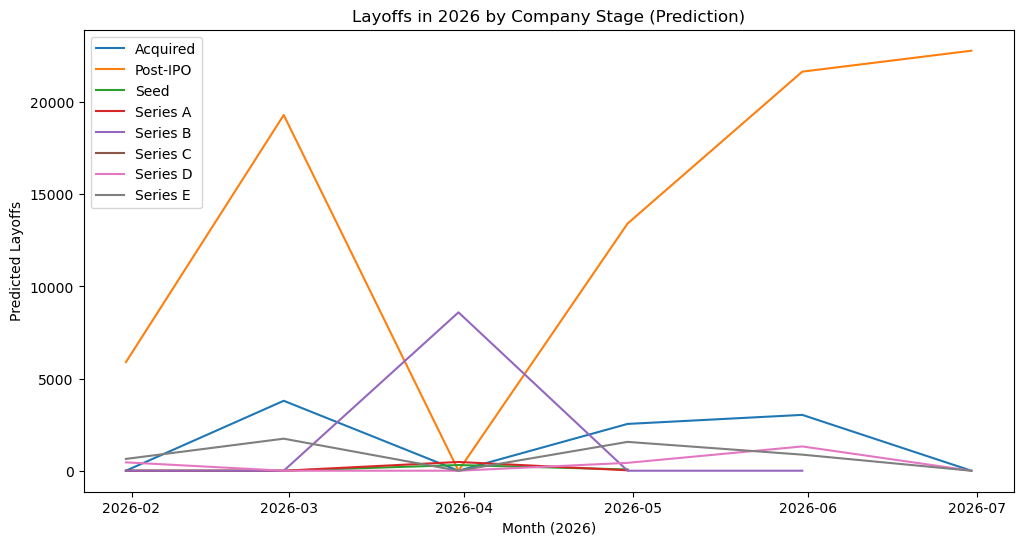

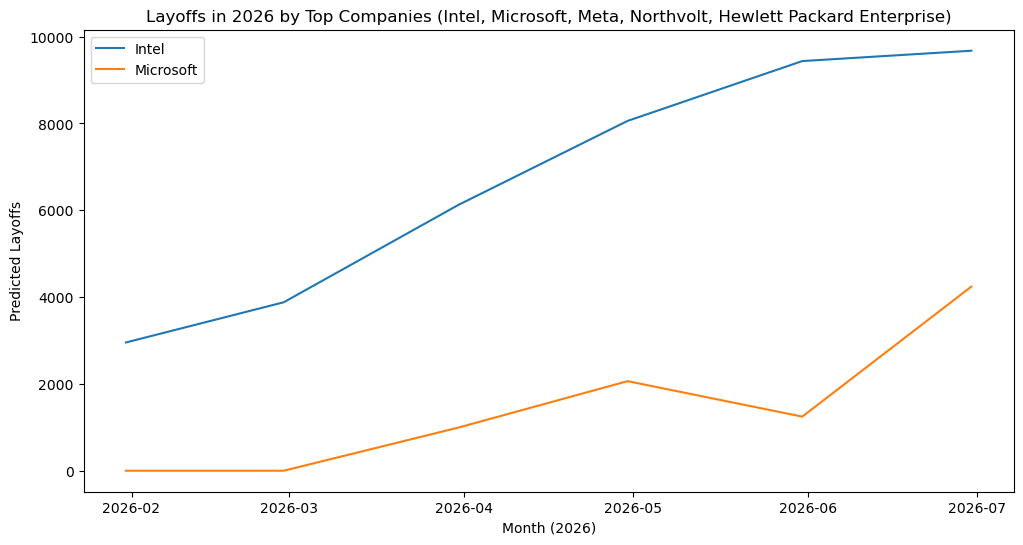

In [67]:
df['Number_laid_off'] = pd.to_numeric(df['Number_laid_off'], errors='coerce')
df = df.dropna(subset=['Number_laid_off'])

# 1. DATA PREPARATION

df2.rename(columns={"MONTH": "ds", "Total laid off": "y"}, inplace=True)
df2['ds'] = pd.to_datetime(df2['ds'], format='%Y-%m')

industry_monthly = df.groupby(['YearMonth', 'Industry'])['Number_laid_off'].sum().reset_index()
stage_monthly = df.groupby(['YearMonth', 'Stage'])['Number_laid_off'].sum().reset_index()
company_monthly = df.groupby(['YearMonth', 'Company'])['Number_laid_off'].sum().reset_index()

# 2. FORECASTING FUNCTIONS

def forecast_by_group(monthly_data, group_col, n_periods=12, min_points=6):
    """
    For each group, fits Prophet to monthly time series.
    Only fits groups with at least `min_points` months with >0 layoffs.
    Returns combined DataFrame of predictions for 2026.
    """
    results = []
    all_groups = monthly_data[group_col].dropna().unique()
    for group in all_groups:
        group_df = monthly_data[monthly_data[group_col]==group][['YearMonth','Number_laid_off']].copy()
        group_df['ds'] = pd.to_datetime(group_df['YearMonth'], format='%Y-%m')
        ts = group_df.set_index('ds').resample('MS').sum().reset_index()
        ts = ts.rename(columns={'ds':'ds', 'Number_laid_off':'y'})
        
        # Fill missing months with zeros
        first, last = ts['ds'].min(), ts['ds'].max()
        full_range = pd.date_range(first, last, freq='MS')
        ts = ts.set_index('ds').reindex(full_range).fillna(0).rename_axis('ds').reset_index()
        
        # Enough points to be meaningful condition
        if (ts['y'] > 0).sum() < min_points:
            continue
            
        # Prophet modeling
        model = Prophet(yearly_seasonality=True)
        model.fit(ts[['ds', 'y']])
        future = model.make_future_dataframe(periods=n_periods, freq='M')
        forecast = model.predict(future)
        forecast_2026 = forecast[(forecast['ds'] >= '2026-01-01') & (forecast['ds'] < '2027-01-01')][['ds', 'yhat']].copy()
        forecast_2026[group_col] = group
        
        # Prevent negative layoffs in output
        forecast_2026['yhat'] = forecast_2026['yhat'].clip(lower=0)
        results.append(forecast_2026)
    if results:
        combined = pd.concat(results)
        combined = combined.rename(columns={'ds':'Month', 'yhat':'Predicted_Layoffs'})
        return combined
    else:
        return pd.DataFrame(columns=['Month', 'Predicted_Layoffs', group_col])

# 3. FORECAST TOTAL LAYOFFS (COMPANIES, MONTHLY)

total_model = Prophet(yearly_seasonality=True)
total_model.fit(df2[['ds','y']])
future = total_model.make_future_dataframe(periods=12, freq='M')
forecast = total_model.predict(future)
forecast_2026 = forecast[(forecast['ds'] >= '2026-01-01') & (forecast['ds'] < '2027-01-01')][['ds', 'yhat']].copy()
forecast_2026 = forecast_2026.rename(columns={'ds':'Month', 'yhat':'Predicted_Layoffs'})
forecast_2026['Predicted_Layoffs'] = forecast_2026['Predicted_Layoffs'].clip(lower=0)  # No negatives

print("Predicted Total Layoffs per Month in 2026:")
print(forecast_2026)

# 4. FORECASTS BY SEGMENT

industry_2026 = forecast_by_group(industry_monthly, 'Industry')
stage_2026 = forecast_by_group(stage_monthly, 'Stage')

# 5. FORECAST TOP 5 COMPANIES

latest_year = df3["Year"].max()
top5 = df3[df3["Year"]==latest_year].sort_values("Total laid off", ascending=False)['Company'].tolist()

print(f"\nTop 5 companies in {latest_year} by layoffs:", ", ".join(top5))

# Filter company_monthly to only top5
top_company_monthly = company_monthly[company_monthly['Company'].isin(top5)]
company_2026 = forecast_by_group(top_company_monthly, 'Company')

# 6. PLOTS

def plot_segment_predictions(df, segment_col, title, max_segs=8):
    plt.figure(figsize=(12,6))
    segs = df[segment_col].dropna().unique()[:max_segs]
    for seg in segs:
        segdf = df[df[segment_col]==seg]
        plt.plot(segdf['Month'], segdf['Predicted_Layoffs'], label=seg)
    plt.title(title)
    plt.xlabel("Month (2026)")
    plt.ylabel("Predicted Layoffs")
    plt.legend()
    plt.show()


plt.figure(figsize=(12,6))
plt.plot(df2['ds'], df2['y'], label='Actual 2020–2025')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (all, Prophet)', linestyle='--')
plt.axvspan(pd.Timestamp("2026-01-01"), pd.Timestamp("2026-12-31"), color="orange", alpha=0.15, label="2026 prediction")
plt.title("Total Monthly Layoffs: Actual + Predicted")
plt.xlabel("Month")
plt.ylabel("Layoffs")
plt.legend()
plt.show()


if not industry_2026.empty:
    plot_segment_predictions(industry_2026, 'Industry', "Layoffs in 2026 by Industry (Prediction)")

if not stage_2026.empty:
    plot_segment_predictions(stage_2026, 'Stage', "Layoffs in 2026 by Company Stage (Prediction)")

if not company_2026.empty:
    plot_segment_predictions(company_2026, 'Company', f"Layoffs in 2026 by Top Companies ({', '.join(top5)})")

In [ ]:
# SAVE TO CSV (OPTIONAL)
##industry_2026.to_csv("layoffs_2026_by_industry.csv", index=False)
##stage_2026.to_csv("layoffs_2026_by_stage.csv", index=False)
##company_2026.to_csv("layoffs_2026_top_companies.csv", index=False)
##forecast_2026.to_csv("layoffs_2026_total.csv", index=False)
##print("All predictions saved as CSV.")